In [21]:
# import tensorflow as tf

# print(tf.__version__)

In [2]:
# import os
# os.environ.get("tf_upgrade_v2")

In [1]:
# !tf_upgrade_v2 \
#   --infile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan.py \
#   --outfile /home/zcxia/TradeMaster/data_synthesis/TimeGAN/timegan_v2.py \
#   --reportfile report.txt

In [21]:
# import tensorflow as tf

# print(tf.__version__)

In [20]:
# import os
# os.environ.get("tf_upgrade_v2")

# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [67]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [11]:
data=pd.read_csv("/home/zcxia/TradeMaster/data/data/dj30/dj30_labeled_3_24.csv").reset_index()

In [12]:
display(data)

index  Unnamed: 0        date        open        high         low  \
0          0           0  2012-01-03   14.621429   14.732143   14.607143   
1          1           1  2012-01-04   14.642857   14.810000   14.617143   
2          2           2  2012-01-05   14.819643   14.948214   14.738214   
3          3           3  2012-01-06   14.991786   15.098214   14.972143   
4          4           4  2012-01-09   15.196429   15.276786   15.048214   
...      ...         ...         ...         ...         ...         ...   
72988  72988       72988  2021-12-27  139.600006  140.869995  139.570007   
72989  72989       72989  2021-12-28  140.600006  142.970001  140.600006   
72990  72990       72990  2021-12-29  142.660004  143.529999  142.320007   
72991  72991       72991  2021-12-30  143.259995  143.699997  142.479996   
72992  72992       72992  2021-12-31  143.199997  145.039993  142.919998   

            close       adjcp   tic     zopen  ...     zd_10     zd_15  \
0       14.686786   12.575916  AAPL -0.004450  ... -0.011415  0.002751   
1       14.765714   12.643501  AAPL -0.008320  ... -0.011415  0.002751   
2       14.929643   12.783867  AAPL -0.007368  ... -0.011415  0.002751   
3       15.085714   12.917509  AAPL -0.006226  ... -0.011415  0.002751   
4       15.061786   12.897021  AAPL  0.008939  ... -0.011415  0.002751   
...           ...         ...   ...       ...  ...       ...       ...   
72988  140.759995  140.217682   WMT -0.008241  ...  0.005428 -0.001702   
72989  142.779999  142.229904   WMT -0.015268  ... -0.009350 -0.013800   
72990  142.710007  142.160172   WMT -0.000350  ... -0.010427 -0.011113   
72991  143.169998  142.618393   WMT  0.000629  ... -0.015422 -0.011231   
72992  144.690002  144.132538   WMT -0.010298  ... -0.024832 -0.018767   

          zd_20     zd_25     zd_30  pct_return  adjcp_filtered  \
0     -0.061124 -0.072128 -0.126481    0.000000       12.575621   
1     -0.061124 -0.072128 -0.126481    0.005374       12.696937   
2     -0.061124 -0.072128 -0.126481    0.011102       12.800068   
3     -0.061124 -0.072128 -0.126481    0.010454       12.870550   
4     -0.061124 -0.072128 -0.126481   -0.001586       12.903865   
...         ...       ...       ...         ...             ...   
72988 -0.005965  0.000262  0.004064    0.009105      140.434421   
72989 -0.019776 -0.013620 -0.011165    0.014351      141.491412   
72990 -0.018369 -0.013554 -0.011524   -0.000490      142.436433   
72991 -0.019225 -0.017298 -0.014566    0.003223      143.289840   
72992 -0.026154 -0.027970 -0.024153    0.010617      144.111956   

       pct_return_filtered  label  stock_type  
0                -0.001100      2           0  
1                 0.000104      2           0  
2                 0.001207      2           0  
3                 0.002026      2           0  
4                 0.002478      2           0  
...                    ...    ...         ...  
72988             0.001502      1           0  
72989             0.003784      1           0  
72990             0.006163      1           0  
72991             0.008511      1           0  
72992             0.010755      1           0  

[72993 rows x 25 columns]

# preprocess data by stock group and regime

Seperate data into groups by (stock_type,regime_type)

In [4]:
stock_group_num=len(data['stock_type'].unique())
regime_num=len(data['label'].unique())

In [6]:
data_by_regime={}

In [23]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data_seg=data.loc[(data['stock_type']==i) & (data['label']==j),['index','open','high','low','close','adjcp','pct_return','adjcp_filtered','pct_return_filtered']]
#         data_dict[(i,j)]=data_seg
        data_seg.to_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')

In [45]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    return intervals

In [51]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [55]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [75]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [76]:
test_data=pd.read_csv('data_seg_0_0.csv')

In [77]:
process_data=get_data_of_same_length(test_data,24)

In [78]:
display(len(process_data))

825

In [ ]:
display(process_data)

[    Unnamed: 0  index       open       high        low      close      adjcp  \
 0           66     66  22.361786  22.851429  22.332144  22.722500  19.456690   
 1           67     67  22.854643  23.000000  22.357143  22.444286  19.218456   
 2           68     68  22.721430  22.745358  22.262142  22.364286  19.149956   
 3           69     69  22.321428  22.547501  22.160713  22.241785  19.045067   
 4           70     70  22.289642  22.310715  21.553928  21.615356  18.508671   
 5           71     71  21.787857  21.795713  20.651787  20.718929  17.741079   
 6           72     72  20.676430  21.785713  20.425358  21.775000  18.645365   
 7           73     73  21.918571  22.151787  21.525356  21.726429  18.603785   
 8           74     74  21.436428  21.597500  20.875713  20.980000  17.964636   
 9           75     75  21.120714  21.236429  20.372143  20.463572  17.522429   
 10          76     76  20.378929  20.595358  19.879286  20.417856  17.483282   
 11          77     77  20.0

In [ ]:
for i in tqdm(range(len(process_data))):
    process_data[i]=minmax_normlization(process_data[i])

In [ ]:
display(process_data)

In [69]:
style_data=real_data_loading('data_seg_0_0.csv', 24)

In [71]:
len(style_data)

2491

In [70]:
display(style_data)

[array([[0.09625889, 0.09625889, 0.72160608, 0.71908292, 0.7138807 ,
         0.71492318, 0.69774543, 0.50515037, 0.69260767, 0.46173681],
        [0.09624516, 0.09624516, 0.72284474, 0.72951557, 0.71988234,
         0.72485333, 0.70732255, 0.52870814, 0.71031814, 0.53167804],
        [0.09623144, 0.09623144, 0.72219593, 0.7258612 , 0.72713189,
         0.72692205, 0.70931789, 0.55860062, 0.71652883, 0.61272649],
        [0.09621771, 0.09621771, 0.71965967, 0.72191211, 0.72012008,
         0.71906079, 0.70173594, 0.53008368, 0.713745  , 0.69395222],
        [0.09620399, 0.09620399, 0.71281786, 0.71967228, 0.71768373,
         0.72065664, 0.70327514, 0.56023979, 0.70626499, 0.7654642 ],
        [0.09619027, 0.09619027, 0.70361662, 0.70965218, 0.70894862,
         0.71232251, 0.69523722, 0.55702436, 0.69815284, 0.82016335],
        [0.09617654, 0.09617654, 0.70503222, 0.70405271, 0.70579923,
         0.70511136, 0.68828246, 0.54600737, 0.69207485, 0.85458965],
        [0.09616282, 0.0961

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [7]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 10000
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [8]:
# Run TimeGAN
generated_data = timegan(style_data, parameters,1)   
print('Finish Synthetic Data Generation')





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


2022-12-20 16:33:29.170293: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-12-20 16:33:29.243699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:3b:00.0
2022-12-20 16:33:29.243883: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.0'; dlerror: libcudart.so.10.0: cannot open shared object file: No such file or directory
2022-12-20 16:33:29.243940: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcublas.so.10.0'; dlerror: libcublas.so.10.0: cannot open shared object file: No such file or directory
2022-12-20 16:33:29.243987: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcufft.so.10.0'; dlerror: libcufft.so.10.0: cannot open shared 

Start Embedding Network Training
step: 0/10000, e_loss: 0.2403
step: 1000/10000, e_loss: 0.0449
step: 2000/10000, e_loss: 0.0273
step: 3000/10000, e_loss: 0.0217
step: 4000/10000, e_loss: 0.0217
step: 5000/10000, e_loss: 0.0182
step: 6000/10000, e_loss: 0.0168
step: 7000/10000, e_loss: 0.0181
step: 8000/10000, e_loss: 0.0171
step: 9000/10000, e_loss: 0.0147
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/10000, s_loss: 0.2431
step: 1000/10000, s_loss: 0.0321
step: 2000/10000, s_loss: 0.0335
step: 3000/10000, s_loss: 0.0291
step: 4000/10000, s_loss: 0.03
step: 5000/10000, s_loss: 0.0266
step: 6000/10000, s_loss: 0.0256
step: 7000/10000, s_loss: 0.0313
step: 8000/10000, s_loss: 0.0318
step: 9000/10000, s_loss: 0.0303
Finish Training with Supervised Loss Only

Start Joint Training
step: 0/10000, d_loss: 1.9685, g_loss_u: 0.8743, g_loss_s: 0.0404, g_loss_v: 0.3803, e_loss_t0: 0.0866
step: 1000/10000, d_loss: 0.7532, g_loss_u: 2.0379, g_loss_s: 0.0357, g_l

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [10]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
    temp_disc = discriminative_score_metrics(style_data, generated_data)
    discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

Instructions for updating:
Please use tf.global_variables instead.


2022-12-20 21:10:48.248384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 21:10:48.248461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 21:11:21.107782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 21:11:21.107837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 21:11:54.447383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 21:11:54.447636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 21:12:27.454403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 21:12:27.454473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 21:12:59.870606: I tensorflow

Discriminative score: 0.1956


## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [12]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(style_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

2022-12-20 22:26:16.082658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 22:26:16.082727: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 22:27:24.370132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 22:27:24.370182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 22:28:31.911317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 22:28:31.911406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 22:29:40.299632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-12-20 22:29:40.299679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2022-12-20 22:30:49.463836: I tensorflow

Predictive score: 0.1082


## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

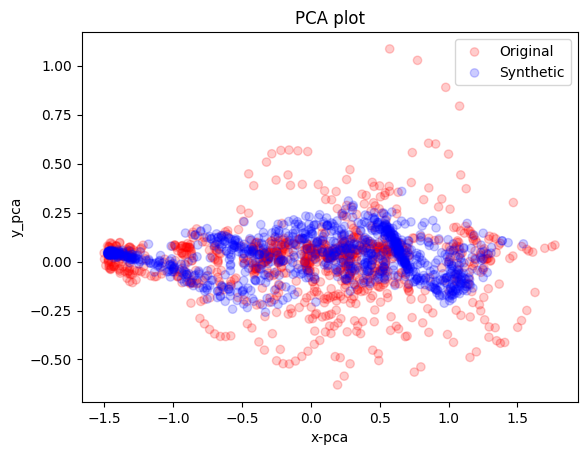

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.163s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.063983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.950867
[t-SNE] KL divergence after 300 iterations: 0.877363


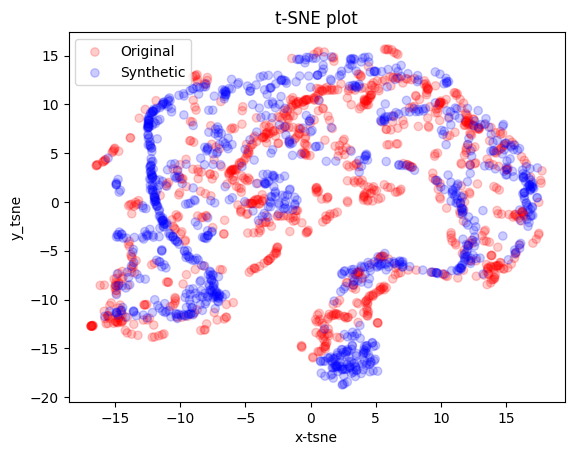

In [13]:
visualization(style_data, generated_data, 'pca')
visualization(style_data, generated_data, 'tsne')